## Segmentation of Nerve from Tri-labeled specimen

In [1]:
import skimage as sk
import numpy as np
import cv2 as cv
import os
from matplotlib import pyplot as plt
from scipy.ndimage import  gaussian_filter, binary_fill_holes
import nibabel as nib
import pandas as pd

Helper functions:

- `view_slice` : visualize 2D level for each steps in segmentation task
- `Segment_Nerve_3D` : segment 3D img as a volume

In [2]:
def view_slice(img, title="", save_as=None):

    fig, ax = plt.subplots(figsize=(4, 4))
    plt.tick_params(axis='both', which='both', top=False,
                    bottom=False, left=False, right=False,
                    labelbottom=False, labelleft=False)
    ax.volume = img

    ax.set_title(title, fontsize=30)
    vmax = img.max()
    ax.imshow(ax.volume, cmap="gray", vmax=vmax)

    if save_as:
        plt.savefig(save_as, format='jpeg')
    plt.show()


def Segment_Nerve_3D(image_stack, 
                     kernel_size=5, 
                     dilation_size=7, 
                     erosion_size=3):
    results = {}
    
    # Raw image
    results['raw'] = image_stack

    # Log adjustment
    img = sk.exposure.adjust_log(image_stack, 0.75)
    results['log'] = img

    # Gaussian filter
    img = gaussian_filter(img, sigma=kernel_size)
    results['gaussian'] = img

    # Otsu thresholding
    thresh = sk.filters.threshold_otsu(img)
    img = img > thresh
    results['otsu'] = img

    # Binary dilation
    kernel = sk.morphology.ball(dilation_size)
    img = sk.morphology.binary_dilation(img, kernel).astype("uint8")
    results['binary_dilation'] = img

    # Hole filling in 3 axes
    fill_hole1 = np.zeros_like(img)
    for frame_idx in range(img.shape[2]):  # top view
        fill_hole1[:, :, frame_idx] = binary_fill_holes(img[:, :, frame_idx])
    fill_hole2 = np.zeros_like(img)
    for frame_idx in range(img.shape[0]):  # front view
        fill_hole2[frame_idx, :, :] = binary_fill_holes(fill_hole1[frame_idx, :, :]) 
    fill_hole3 = np.zeros_like(img)
    for frame_idx in range(img.shape[1]):  # side view
        fill_hole3[:, frame_idx, :] = binary_fill_holes(fill_hole2[:, frame_idx, :])
    results['filled'] = fill_hole3

    # Binary erosion
    kernel = sk.morphology.ball(erosion_size)
    img = sk.morphology.binary_erosion(fill_hole3, kernel).astype("uint8")
    results['binary_erosion'] = img
    
    return results, img

Visualizing Segmentation

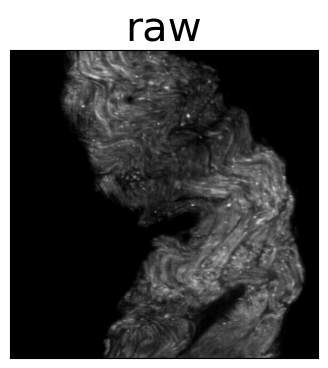

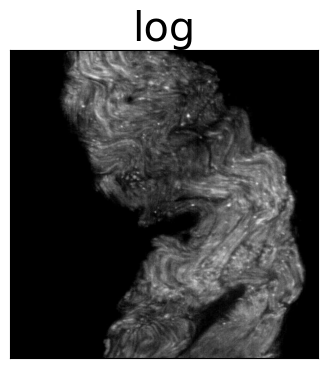

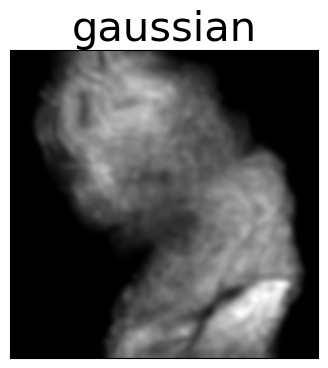

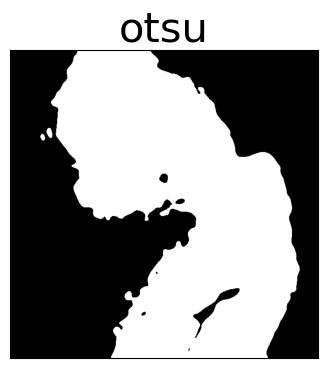

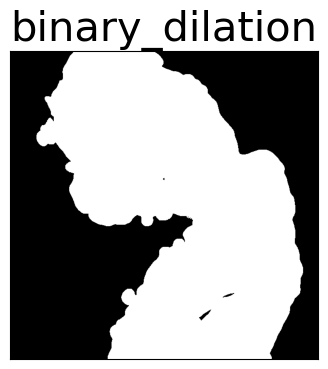

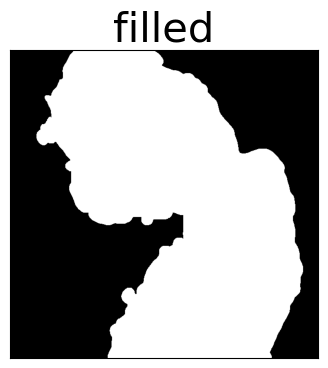

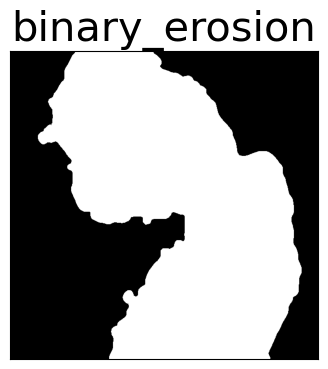

In [9]:
import os
import numpy as np
from PIL import Image

dir = "./ihc_example/"

jpeg_files = [f.path for f in os.scandir(dir) if f.is_file() and f.name.endswith('.jpeg')]

# Read first image to get dimensions
first_image = np.array(Image.open(jpeg_files[0]))
height, width = first_image.shape

image_stack = np.zeros((height, width, len(jpeg_files)), dtype=np.uint8)

for i, imgpath in enumerate(jpeg_files):
    # Open with PIL and convert to numpy array
    image = np.array(Image.open(imgpath))
    image_stack[:, :, i] = image

results, _ = Segment_Nerve_3D(
    image_stack,
    kernel_size=5,
    dilation_size=7,
    erosion_size=3
)

idx = 30
for key, value in results.items():
    savename = key + ".jpeg"
    view_slice(
        value[:, :, idx],
        title=key
        # , save_as=savename
    )
